In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Parameters

ticker = 'AAPL'
start = '2010-01-01'
today = date.today().strftime('%Y-%m-%d')
look_back = 100
epochs = 100
batch_size = 64

In [ ]:
# Load data

def load_data(ticker):
    data = yf.download(ticker, start, today)
    data = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    data.reset_index(inplace=True)
    return data

data = load_data(ticker)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data

Price,Date,Open,High,Low,Close,Adj Close,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.447412,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.458559,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.355827,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.344078,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.386256,447610800
...,...,...,...,...,...,...,...
3758,2024-12-09,241.830002,247.240005,241.750000,246.750000,246.750000,44649200
3759,2024-12-10,246.889999,248.210007,245.339996,247.770004,247.770004,36914800
3760,2024-12-11,247.960007,250.800003,246.259995,246.490005,246.490005,45205800


In [ ]:
df = data[['Close']]

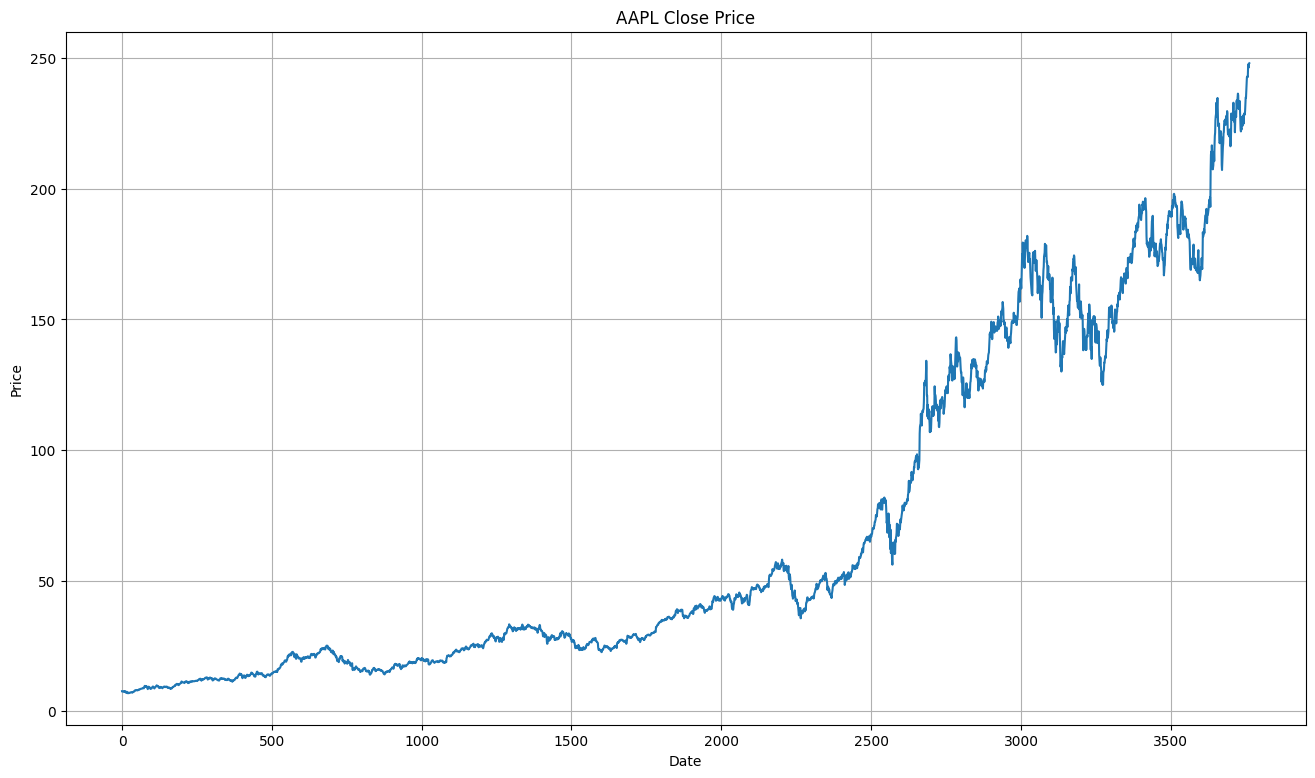

In [ ]:
# Plot closing price

plt.figure(figsize=(16, 9))
plt.plot(df['Close'])
plt.title(f'{ticker} Close Price')
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [ ]:
# Train test split

train_size = int(len(df)*0.80)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (3010, 1)
Test shape: (753, 1)


In [ ]:
# Scaling

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Close']])

In [ ]:
x_train = []
y_train = []

for i in range(look_back, train_scaled.shape[0]):
    x_train.append(train_scaled[i-look_back:i, 0])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Model

def build_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - loss: 0.0085 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 327ms/step - loss: 4.0981e-04 - val_loss: 6.7836e-04 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - loss: 4.1636e-04 - val_loss: 6.3248e-04 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 314ms/step - loss: 3.4927e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 394ms/step - loss: 3.2730e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 327ms/step - loss: 3.2783e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 3.5525e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 338ms/step - loss: 3.5509e-04 - val_loss: 6.7858e-04 - learning_rate: 0.0010
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 3

In [ ]:
# Test data

past_days = df.iloc[train_size - look_back:train_size] if train_size > look_back else df.iloc[0:train_size]
final_df = pd.concat([past_days, test], ignore_index=True)
test_scaled = scaler.transform(final_df[['Close']])

In [ ]:
x_test = []
y_test = []

for i in range(look_back, test_scaled.shape[0]):
    x_test.append(test_scaled[i-look_back:i, 0])
    y_test.append(test_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Prediction on test set

y_pred = model.predict(x_test)
y_test = y_test.reshape(-1,1)
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


In [ ]:
# Errors

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)

MSE: 27.421848643149687
MAE: 4.2044165055273695
RMSE: 5.236587499808409
R² Score: 0.9640670403716126


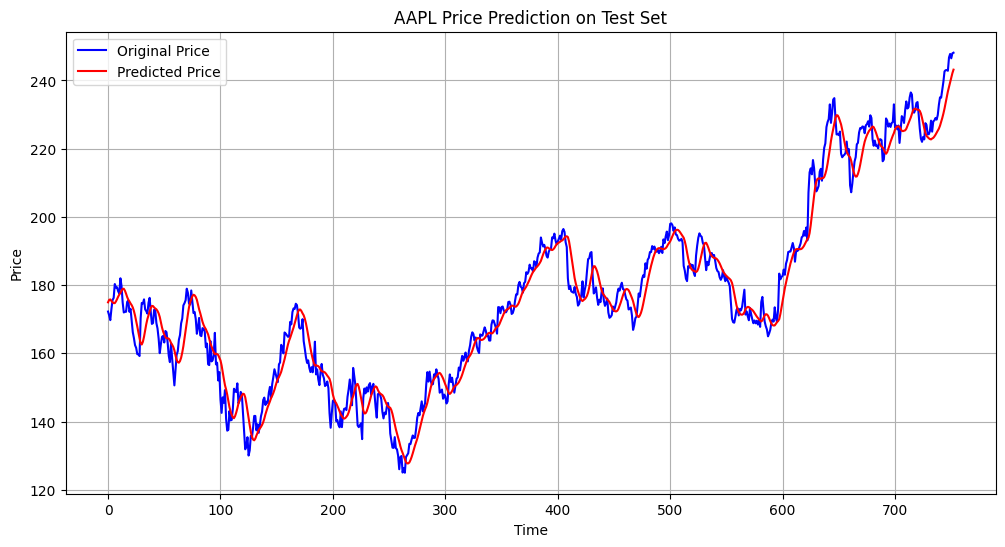

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, 'b', label="Original Price")
plt.plot(y_pred_rescaled, 'r', label="Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.title(f'{ticker} Price Prediction on Test Set')
plt.show()

In [ ]:
# Forecast next day

last_100_days = df[-look_back:]['Close'].values.reshape(-1,1)
last_100_days_scaled = scaler.transform(last_100_days)

X_future = []
X_future.append(last_100_days_scaled)
X_future = np.array(X_future)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

next_day_pred = model.predict(X_future)
next_day_pred_rescaled = scaler.inverse_transform(next_day_pred)

print(f"Forecasted Close Price for the next day: {next_day_pred_rescaled[0,0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Forecasted Close Price for the next day: 244.04
